In [1]:
# パッケージインポート
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import datetime as dt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import time
import os
import glob
import codecs
sns.set()
'''
numpy 1.18.1
matplotlib 3.1.3
seaborn 0.10.0
pandas 1.0.3
sklearn 0.22.1
'''

'\nnumpy 1.18.1\nmatplotlib 3.1.3\nseaborn 0.10.0\npandas 1.0.3\nsklearn 0.22.1\n'

In [2]:
import sys
'''
3.7.7 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
'''
print(sys.version)

3.7.7 (default, Mar 23 2020, 23:19:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
# バージョン確認
'''
numpy 1.18.1
scipy 1.4.1
matplotlib 3.1.3
seaborn 0.10.0
pandas 1.0.3
dateutil 2.8.1
sklearn 0.22.1
optuna 1.3.0
'''
print('numpy', np.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)
print('pandas', pd.__version__)
print('sklearn', sklearn.__version__)

numpy 1.18.1
matplotlib 3.1.3
seaborn 0.10.0
pandas 1.0.3
sklearn 0.22.1


In [4]:
# pathの確認
path = os.getcwd()
print(path)

C:\Users\ryousuke.kiridoshi


# クラスタリング_ユーザー

In [5]:
file='kz.csv'
df = pd.read_csv(file, dtype={'user_id':str, 'order_id':str})
df=df[['event_time', 'category_code', 'brand', 'price', 'user_id', 'order_id']]
df=df.dropna()
df['event_time']=df['event_time'].str[:-4]
df['event_time']=pd.to_datetime(df['event_time'])
df=df[df['event_time']>=dt.datetime(2020,1,1)]
df=df.sort_values('event_time')
# ブランドとカテゴリーを結合する
df_cat_split=df['category_code'].str.split('.', expand=True)
df_cat_split.loc[(pd.isna(df_cat_split[2])), 2]=df_cat_split[1]
df_cat_split[3]=df_cat_split[1]+'.'+df_cat_split[2]
df['category']=df_cat_split[3].values
df['brand_category']=df['brand']+'.'+df['category']
# 各カラムのユニーク数
print('order_id', df['order_id'].unique().shape[0])
print('user_id', df['user_id'].unique().shape[0])
print('category_code', df['category_code'].unique().shape[0])
print('brand', df['brand'].unique().shape[0])
print('brand_category', df['brand_category'].unique().shape[0])
'''
order_id 331424
user_id 203235
category_code 123
brand 570
brand_category 1375
'''
display(df)

order_id 331424
user_id 203235
category_code 123
brand 570
brand_category 1375


,event_time,category_code,brand,price,user_id,order_id,category,brand_category
68120,2020-01-05 04:06:18,electronics.audio.headphone,apple,203.68,1515915625484572166,2348710347105370326,audio.headphone,apple.audio.headphone
64028,2020-01-05 04:09:00,computers.notebook,microlab,27.75,1515915625484571705,2348709909622685923,notebook.notebook,microlab.notebook.notebook
68583,2020-01-05 04:35:21,construction.tools.screw,samsung,11.55,1515915625484572228,2348710405431361995,tools.screw,samsung.tools.screw
63754,2020-01-05 04:44:43,appliances.kitchen.washer,lg,578.68,1515915625484571673,2348709879230758992,kitchen.washer,lg.kitchen.washer
68307,2020-01-05 04:56:26,accessories.bag,rivacase,28.91,1515915625484572198,2348710371440722247,bag.bag,rivacase.bag.bag
...,...,...,...,...,...,...,...,...
2633515,2020-11-21 10:08:54,electronics.video.tv,lg,370.35,1515915625513809944,2388440981134693941,video.tv,lg.video.tv
2633516,2020-11-21 10:10:01,electronics.smartphone,oppo,138.87,1515915625514888605,2388440981134693942,smartphone.smartphone,oppo.smartphone.smartphone
2633517,2020-11-21 10:10:13,electronics.smartphone,apple,418.96,1515915625514891148,2388440981134693943,smartphone.smartphone,apple.smartphone.smartphone
2633518,2020-11-21 10:10:30,appliances.personal.scales,vitek,12.48,1515915625514834281,2388440981134693944,personal.scales,vitek.personal.scales


In [6]:
# データを半分に分ける
df_before=df.iloc[:int(len(df)/2.),:]
df_after=df.iloc[int(len(df)/2.):,:]

# どちらのデータにも存在しているuser_idを抽出
df_target=pd.merge(df_before[['user_id']], df_after[['user_id']], on=['user_id'], how='inner')['user_id'].unique()
df_target=pd.DataFrame(df_target, columns=['user_id'])
# どちらのデータにも存在しているuser_idを対象にしたデータを作る
df_before=df_before[df_before['user_id'].isin(df_target['user_id'].values)]
df_after=df_after[df_after['user_id'].isin(df_target['user_id'].values)]
# 2つのデータの期間とuser_idのユニーク数を表示
print('before\n', df_before['event_time'].min())
print('', df_before['event_time'].max())
print('\nafter\n',df_after['event_time'].min())
print('', df_after['event_time'].max())
print('\nUnique User Cnt', len(df_target))
'''
before
 2020-01-05 04:35:21
 2020-08-14 08:58:58

after
 2020-08-14 08:59:17
 2020-11-21 09:59:55

Unique User Cnt 15527
'''

before
 2020-01-05 04:35:21
 2020-08-14 08:58:58

after
 2020-08-14 08:59:17
 2020-11-21 09:59:55

Unique User Cnt 15527


'\nbefore\n 2020-01-05 04:35:21\n 2020-08-14 08:58:58\n\nafter\n 2020-08-14 08:59:17\n 2020-11-21 09:59:55\n\nUnique User Cnt 15527\n'

In [7]:
# ピボットでマートを作る
def df_pivot(df, index, columns, values, aggfunc):
    df_mart=df.pivot_table(index=index, columns=columns, values=values, aggfunc=aggfunc).reset_index()
    df_mart=df_mart.fillna(0)
    return df_mart

# LDAに食わせる用の加工
def df_to_np(df_mart):
    df_data=df_mart.copy().iloc[:,1:]
    df_data = df_data.values
    return df_data

row='user_id'
col='brand_category'
val='price'

df_mart=df_pivot(df_before, row, col, val, 'sum')
df_mart2=df_pivot(df_after, row, col, val, 'sum')

# df_martとdf_mart2で重複していないカラム名をとってくる
after=np.hstack((df_mart.columns.values, df_mart2.columns.values))
unique_after, counts_after = np.unique(after, return_counts=True)
non_dep_after=unique_after[counts_after == 1]

# さっきの重複していないカラム名の中で、df_martに入っていてdf_mart2に入っていないカラム名を抽出
before=np.hstack((non_dep_after, df_mart.columns.values))
unique_before, counts_before = np.unique(before, return_counts=True)
dep_before=unique_before[counts_before != 1]

# df_mart2にdf_mart固有のカラム名の列を追加
for col in dep_before:
    df_mart2[col]=0.

# これでdf_martとdf_mart2のカラムがそろう
df_mart=df_mart[df_mart.columns]
df_mart2=df_mart2[df_mart.columns]
# LDAに食わせる用の加工
df_data=df_to_np(df_mart)
df_data2=df_to_np(df_mart2)
display(df_mart)
display(df_mart2)
display(df_data)
display(df_data2)

brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zalman.components.cooler,zeppelin.components.memory,zeta.living_room.chair,zhorka.ski.ski,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet
0,1515915625440099873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625440881369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625440936206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625440936593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1515915625440936958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,1515915625514600775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15523,1515915625514601679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15524,1515915625514657024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15525,1515915625514704541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zalman.components.cooler,zeppelin.components.memory,zeta.living_room.chair,zhorka.ski.ski,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet
0,1515915625440099873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625440881369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625440936206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625440936593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1515915625440936958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,1515915625514600775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15523,1515915625514601679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15524,1515915625514657024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15525,1515915625514704541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

topic_cnt: 6


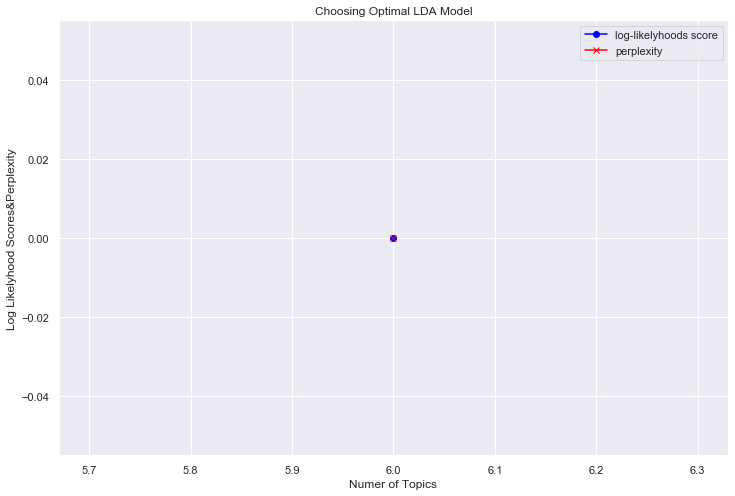

IndexError: list index out of range

In [8]:
# LDAのモデルを作る関数
def model_plot_opt(tfidf_data, topic_list, plot_enabled=True):
    # 定義
    n_topics = list(topic_list.astype(int))
    perplexities=[]
    log_likelyhoods_scores=[]
    models=[]
    search_params = {'n_components': n_topics}
    minmax_1 = MinMaxScaler()
    minmax_2 = MinMaxScaler()

    # 設定したトピック数ごとのモデルを作る
    for i in n_topics:
        print('topic_cnt:',i)
        lda = LatentDirichletAllocation(n_components=i,random_state=0,
                                        learning_method='batch',
                                        max_iter=25)
        lda.fit(tfidf_data)
        lda_perp = lda.perplexity(tfidf_data)
        log_likelyhoods_score = lda.score(df_data)
        perplexities.append(lda_perp)
        log_likelyhoods_scores.append(log_likelyhoods_score)
        models.append(lda)

    # 対数尤度とperplexityを正規化したものをプロット
    if plot_enabled:
        # 正規化
        log_likelyhoods_scores_std=minmax_1.fit_transform(np.array(log_likelyhoods_scores).reshape(len(log_likelyhoods_scores),1))
        perplexities_std=minmax_2.fit_transform(np.array(perplexities).reshape(len(perplexities),1))
        # 図作成
        plt.figure(figsize=(12, 8))
        ax=plt.subplot(1,1,1)
        ax.plot(n_topics, log_likelyhoods_scores_std, marker='o', color='blue', label='log-likelyhoods score')
        ax.set_title("Choosing Optimal LDA Model")
        ax.set_xlabel("Numer of Topics")
        ax.set_ylabel("Log Likelyhood Scores&Perplexity")
        ax.plot(n_topics, perplexities_std, marker='x', color='red', label='perplexity')
        plt.legend()
        plt.show()

    return models, log_likelyhoods_scores_std, perplexities_std

# モデルのリストと正規化した対数尤度とperplexityを定義
models_list, log_likelyhoods_scores_std, perplexities_std = model_plot_opt(df_data, np.linspace(2,8,7))
# 適当に6にする
lda=models_list[4]
print('topic_num:', lda.components_.shape[0])
'''
topic_num: 6
'''

In [10]:
# 正規化した対数尤度とperplexityの差が最も小さかった時のトピック数のモデルを"lda"として定義
diffs_=[abs(log[0]-perp[0]) for (log, perp) in zip(log_likelyhoods_scores_std, perplexities_std)]
print('最も小さい時のindex(番目):', diffs_.index(min(diffs_)))
lda=models_list[diffs_.index(min(diffs_))]
print('topic_num:', lda.components_.shape[0])

# 適当に6にする
lda=models_list[4]
print('topic_num:', lda.components_.shape[0])

最も小さい時のindex(番目): 0
topic_num: 6
topic_num: 6


In [11]:
# 各トピックにおける、商品の出現確率上位20を取得する関数
def component(lda, features):
    df_component=pd.DataFrame()
    for tn in range(lda.components_.shape[0]):
        row = lda.components_[tn]
        words = [features[i] for i in row.argsort()[:-20-1:-1]]
        df_component[tn]=words
        words = ', '.join([features[i] for i in row.argsort()[:-20-1:-1]])
    return df_component

# 各トピックにおける、商品の出現確率上位5まで抽出
features = df_mart.iloc[:,1:].columns.values
df_component=component(lda, features)
display(df_component.iloc[:5,:])

,0,1,2,3,4,5
0,asus.notebook.notebook,apple.smartphone.smartphone,lenovo.notebook.notebook,samsung.smartphone.smartphone,lg.kitchen.refrigerators,samsung.video.tv
1,birjusa.kitchen.refrigerators,apple.notebook.notebook,beko.environment.air_conditioner,hp.notebook.notebook,samsung.kitchen.washer,samsung.kitchen.refrigerators
2,beko.kitchen.washer,lg.video.tv,apple.tablet.tablet,apple.audio.headphone,lg.kitchen.washer,ava.environment.air_conditioner
3,ava.kitchen.refrigerators,huawei.smartphone.smartphone,samsung.tablet.tablet,sony.glove.glove,bosch.kitchen.refrigerators,oppo.smartphone.smartphone
4,xiaomi.video.tv,dyson.environment.vacuum,xiaomi.smartphone.smartphone,beko.kitchen.refrigerators,bosch.kitchen.hood,indesit.kitchen.refrigerators


In [12]:
# user_idごとの所属確率が最も高いトピックを列として追加したdfを作成
def create_topic_no(df_mart, df_data, lda):
    df_id_cluster=df_mart[[row]]
    df_topic=pd.DataFrame(lda.transform(df_data))
    topic=df_topic.loc[:,:].idxmax(axis=1).values
    df_id_cluster['topic']=topic
    return df_id_cluster

df_id_cluster=create_topic_no(df_mart, df_data, lda)
df_id_cluster2=pd.merge(df_mart, df_id_cluster, on=['user_id'], how='left')
# 各トピックにおける、商品の平均購入数を抽出
display(df_id_cluster2.groupby(['topic']).mean().T.sort_values(0,ascending=False))

C:\Users\ryousuke.kiridoshi\Anaconda3\envs\yahtra\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


topic,0,1,2,3,4,5
brand_category,,,,,,
asus.notebook.notebook,155.332034,7.174977,6.187974,7.777501,3.714612,4.360834
birjusa.kitchen.refrigerators,27.092286,1.609190,0.930373,1.229255,3.785596,1.810499
samsung.smartphone.smartphone,9.493499,39.723656,15.734938,480.424560,19.454341,20.946763
xiaomi.video.tv,7.051596,0.377097,0.344179,0.929069,1.198085,0.943928
ava.kitchen.refrigerators,6.012739,0.715150,1.197446,0.788772,1.019268,1.186399
...,...,...,...,...,...,...
karcher.steam_cleaner.steam_cleaner,0.000000,0.140871,0.182554,0.000000,1.415542,0.060837
karcher.tools.pump,0.000000,0.000000,0.000000,0.000000,0.000000,0.060834
kaspersky.notebook.notebook,0.000000,0.000000,0.000000,0.017517,0.000000,0.006771


In [13]:
# df_martに対してトピック番号をつけてあげる
df_topic_result=df_mart.copy()
top_price_brand_before=df_mart.iloc[:,1:].idxmax(axis=1).values
# user_idごとの所属確率が最も高いトピックを列として追加
df_topic_result['topic_before']=create_topic_no(df_mart, df_data, lda)['topic'].values
# user_idごとの購入額が最も高いブランドを列として追加
df_topic_result['top_price_brand_before']=top_price_brand_before

# df_mart2に対してトピック番号をつけてあげる
df_topic_result2=df_mart2.copy()
top_price_brand_after=df_mart2.iloc[:,1:].idxmax(axis=1).values
# user_idごとの所属確率が最も高いトピックを列として追加
df_topic_result2['topic_after']=create_topic_no(df_mart2, df_data2, lda)['topic'].values
# user_idごとの購入額が最も高いブランドを列として追加
df_topic_result2['top_price_brand_after']=top_price_brand_after

# df_martとdf_mart2をJOIN
df_topic_result=pd.merge(df_topic_result, df_topic_result2[['user_id','topic_after','top_price_brand_after']], on=['user_id'], how='left')
display(df_topic_result)

C:\Users\ryousuke.kiridoshi\Anaconda3\envs\yahtra\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ryousuke.kiridoshi\Anaconda3\envs\yahtra\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet,topic_before,top_price_brand_before,topic_after,top_price_brand_after
0,1515915625440099873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,casio.camera.video,4,whirlpool.kitchen.refrigerators
1,1515915625440881369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,apple.smartphone.smartphone,4,garmin.clocks.clocks
2,1515915625440936206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,vivo.smartphone.smartphone,1,apple.smartphone.smartphone
3,1515915625440936593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,ava.environment.air_conditioner,2,lenovo.notebook.notebook
4,1515915625440936958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,samsung.video.tv,3,samsung.smartphone.smartphone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,1515915625514600775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,apple.smartphone.smartphone,3,samsung.smartphone.smartphone
15523,1515915625514601679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,apple.smartphone.smartphone,1,apple.smartphone.smartphone
15524,1515915625514657024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,asus.notebook.notebook,3,hp.notebook.notebook
15525,1515915625514704541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,samsung.smartphone.smartphone,3,samsung.smartphone.smartphone


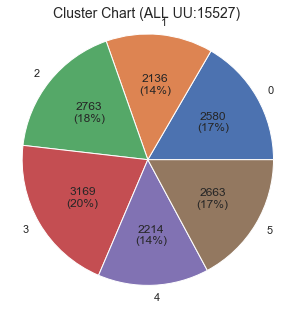

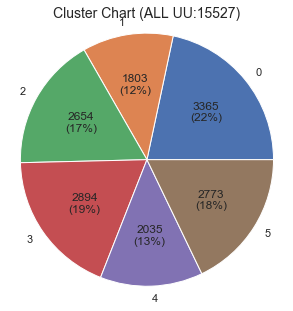

In [14]:
# plot Cluster Chart
def pct_abs(pct, raw_data):
    absolute = int(np.sum(raw_data)*(pct/100.))
    return '{:d}\n({:.0f}%)'.format(absolute, pct) if pct > 5 else ''

def plot_chart(y_km):
    km_label=pd.DataFrame(y_km).rename(columns={0:'cluster'})
    km_label['val']=1
    km_label=km_label.groupby('cluster')[['val']].count().reset_index()
    fig=plt.figure(figsize=(5,5))
    ax=plt.subplot(1,1,1)
    ax.pie(km_label['val'],labels=km_label['cluster'], autopct=lambda p: pct_abs(p, km_label['val']))#, autopct="%1.1f%%")
    ax.axis('equal')
    ax.set_title('Cluster Chart (ALL UU:{})'.format(km_label['val'].sum()),fontsize=14)
    plt.show()

plot_chart(df_topic_result['topic_before'].values)
plot_chart(df_topic_result['topic_after'].values)

In [15]:
display(df_topic_result.pivot_table(index='topic_before', columns='topic_after', values='user_id', aggfunc='count'))

topic_after,0,1,2,3,4,5
topic_before,,,,,,
0,757,225,461,382,323,433
1,366,576,318,357,225,294
2,636,266,702,439,295,426
3,563,311,480,968,347,500
4,451,204,333,323,435,468
5,592,221,361,426,411,652


In [16]:
row='user_id'
col='brand_category'
val='order_id'

df_mart=df_pivot(df_before, row, col, val, 'count')
df_mart2=df_pivot(df_after, row, col, val, 'count')

# df_martとdf_mart2で重複していないカラム名をとってくる
after=np.hstack((df_mart.columns.values, df_mart2.columns.values))
unique_after, counts_after = np.unique(after, return_counts=True)
non_dep_after=unique_after[counts_after == 1]

# さっきの重複していないカラム名の中で、df_martに入っていてdf_mart2に入っていないカラム名を抽出
before=np.hstack((non_dep_after, df_mart.columns.values))
unique_before, counts_before = np.unique(before, return_counts=True)
dep_before=unique_before[counts_before != 1]

# df_mart2にdf_mart固有のカラム名の列を追加
for col in dep_before:
    df_mart2[col]=0

# これでdf_martとdf_mart2のカラムがそろう
df_mart=df_mart[df_mart.columns]
df_mart2=df_mart2[df_mart.columns]

display(df_mart)
display(df_mart2)

brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zalman.components.cooler,zeppelin.components.memory,zeta.living_room.chair,zhorka.ski.ski,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet
0,1515915625440099873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625440881369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625440936206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625440936593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1515915625440936958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,1515915625514600775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15523,1515915625514601679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15524,1515915625514657024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15525,1515915625514704541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zalman.components.cooler,zeppelin.components.memory,zeta.living_room.chair,zhorka.ski.ski,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet
0,1515915625440099873,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
1,1515915625440881369,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
2,1515915625440936206,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
3,1515915625440936593,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
4,1515915625440936958,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,1515915625514600775,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
15523,1515915625514601679,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
15524,1515915625514657024,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
15525,1515915625514704541,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0


In [17]:
n=2
m=0
user_id_n_m=df_topic_result[(df_topic_result['topic_before']==n)&(df_topic_result['topic_after']==m)]['user_id'].values
df_b_n_m=df_mart[df_mart['user_id'].isin(user_id_n_m)]
df_a_n_m=df_mart2[df_mart2['user_id'].isin(user_id_n_m)]
display(df_b_n_m)
display(df_a_n_m)

brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zalman.components.cooler,zeppelin.components.memory,zeta.living_room.chair,zhorka.ski.ski,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet
14,1515915625440940212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,1515915625440960555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,1515915625440966264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,1515915625440983652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,1515915625440985279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15408,1515915625512927530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15434,1515915625513717297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15508,1515915625514022418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15512,1515915625514169292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


brand_category,user_id,aeg.kitchen.dishwasher,aeg.kitchen.hood,aeg.kitchen.oven,aeg.kitchen.washer,aerocool.components.cooler,aerocool.components.power_supply,aerocool.living_room.chair,aerocool.toys.toys,aimoto.clocks.clocks,...,zalman.components.cooler,zeppelin.components.memory,zeta.living_room.chair,zhorka.ski.ski,zlatek.living_room.chair,zowie.peripherals.keyboard,zowie.peripherals.mouse,zwilling.kitchen.chair,zwilling.kitchen.table,zwilling.living_room.cabinet
14,1515915625440940212,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
46,1515915625440960555,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
57,1515915625440966264,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
78,1515915625440983652,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
80,1515915625440985279,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15408,1515915625512927530,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
15434,1515915625513717297,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
15508,1515915625514022418,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0
15512,1515915625514169292,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0


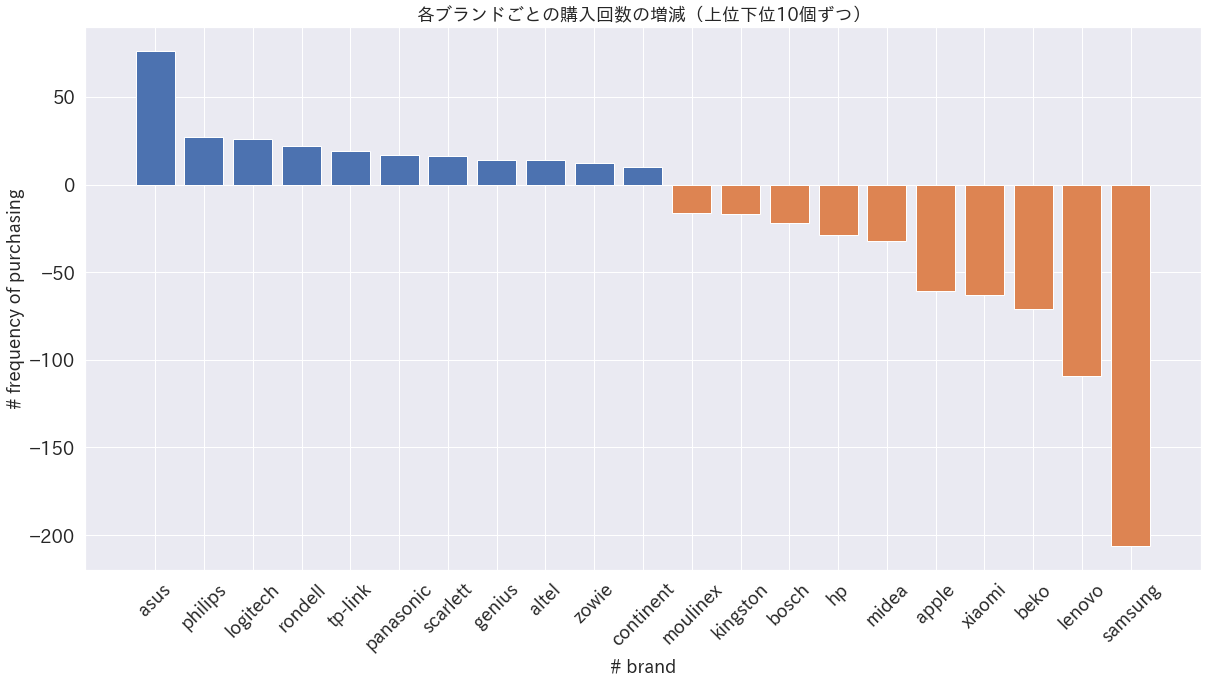

In [47]:
df_diff_n_m=df_a_n_m.iloc[:,1:]-df_b_n_m.iloc[:,1:]
df_diff_n_m.index=df_a_n_m['user_id'].values
df_diff_n_m=df_diff_n_m.T
df_diff_n_m['col']=df_diff_n_m.index
df_diff_n_m['brand']=df_diff_n_m['col'].str.split('.', expand=True).iloc[:,0].values
df_diff_n_m=pd.DataFrame(df_diff_n_m.groupby(['brand']).sum().T.sum()).sort_values(0, ascending=False)

# 各ブランドごとの購入回数の増減をプロット
fig=plt.figure(figsize=(20,10))
plt.bar(df_diff_n_m.index[:11], df_diff_n_m[0][:11])
plt.bar(df_diff_n_m.index[-10:], df_diff_n_m[0][-10:])
plt.rcParams["font.family"] = "IPAexGothic"
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)
plt.xlabel('# brand', fontsize=18)
plt.ylabel('# frequency of purchasing', fontsize=18)
plt.title('各ブランドごとの購入回数の増減（上位下位10個ずつ）', fontsize=18)
plt.show()

In [182]:
df_diff_n_m=df_a_n_m.iloc[:,1:]-df_b_n_m.iloc[:,1:]
df_diff_n_m.index=df_a_n_m['user_id'].values
pd.DataFrame(df_diff_n_m.sum()).sort_values(0, ascending=False)

,0
brand_category,
asus.notebook.notebook,95.0
logitech.peripherals.mouse,23.0
tp-link.network.router,19.0
philips.iron.iron,19.0
panasonic.telephone.telephone,18.0
...,...
samsung.peripherals.monitor,-46.0
samsung.tablet.tablet,-52.0
beko.environment.air_conditioner,-77.0


In [183]:
statistics=df_diff_n_m.describe()
statistics.T.to_csv('desc.csv')
statistics.T

,count,mean,std,min,25%,50%,75%,max
brand_category,,,,,,,,
aeg.kitchen.dishwasher,631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
aeg.kitchen.hood,631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
aeg.kitchen.oven,631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
aeg.kitchen.washer,631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
aerocool.components.cooler,631.0,-0.001585,0.039809,-1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
zowie.peripherals.keyboard,631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
zowie.peripherals.mouse,631.0,0.019017,0.194250,0.0,0.0,0.0,0.0,4.0
zwilling.kitchen.chair,631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [137]:
print(statistics.columns.values[statistics.loc['mean',:]>0].shape)
print(statistics.columns.values[statistics.loc['mean',:]<0].shape)
print(statistics.columns.values[statistics.loc['mean',:]==0].shape)

(197,)
(266,)
(504,)


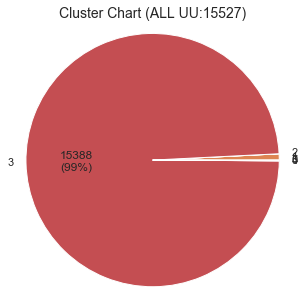

In [30]:
row='user_id'
col='brand_category'
val='price'

df_mart=df_pivot(df_before, row, col, val, 'sum')
df_mart2=df_pivot(df_after, row, col, val, 'sum')

# df_martとdf_mart2で重複していないカラム名をとってくる
after=np.hstack((df_mart.columns.values, df_mart2.columns.values))
unique_after, counts_after = np.unique(after, return_counts=True)
non_dep_after=unique_after[counts_after == 1]

# さっきの重複していないカラム名の中で、df_martに入っていてdf_mart2に入っていないカラム名を抽出
before=np.hstack((non_dep_after, df_mart.columns.values))
unique_before, counts_before = np.unique(before, return_counts=True)
dep_before=unique_before[counts_before != 1]

# df_mart2にdf_mart固有のカラム名の列を追加
for col in dep_before:
    df_mart2[col]=0

# これでdf_martとdf_mart2のカラムがそろう
df_mart=df_mart[df_mart.columns]
df_mart2=df_mart2[df_mart.columns]
# LDAに食わせる用の加工
ss=StandardScaler()
df_data=ss.fit_transform(df_mart.iloc[:,1:].values)
ss=StandardScaler()
df_data2=ss.fit_transform(df_mart2.iloc[:,1:].values)

def km_cluster(X, k):
    km=KMeans(n_clusters=k,\
              init="k-means++",\
              random_state=0)
    y_km=km.fit_predict(X)
    return y_km,km

# k=6でクラスタリング
y_km,km=km_cluster(df_data, 6)
plot_chart(y_km)

In [33]:
df_kmeans=df_mart.copy()
df_kmeans['cluster']=y_km
# 各トピックにおける、商品の平均購入数を抽出
df_kmeans.groupby(['cluster']).mean().T.sort_values(0,ascending=False)

cluster,0,1,2,3,4,5
brand_category,,,,,,
samsung.smartphone.smartphone,675.136667,148.893833,0.00,113.980018,0.00,17.786923
gigabyte.components.videocards,632.300000,3.832750,1755.50,1.597799,0.00,0.000000
amd.components.cpu,235.710000,6.035250,0.00,1.026319,0.00,0.000000
intel.components.cpu,221.673333,0.000000,1534.65,1.003814,0.00,0.000000
apple.audio.headphone,216.033333,5.400833,0.00,6.197273,0.00,15.667692
...,...,...,...,...,...,...
gorenje.kitchen.dishwasher,0.000000,0.000000,0.00,0.837806,0.00,0.000000
gorenje.kitchen.hood,0.000000,1.542833,0.00,0.537546,1944.30,0.000000
gorenje.kitchen.microwave,0.000000,0.000000,0.00,0.052641,0.00,0.000000
